In [245]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from skimage.io import imread
import glob
import scipy.io

#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Loading images in Set 1

In [300]:
def load_images(set):
    '''
    A function to load images in a set
    '''
    
    
    f_images=glob.glob("task3/Set"+str(set)+"/*.jpg")
    images=[]
    n_imgs=len(f_images)
    for i in range(n_imgs):
        images.append(imread("task3/Set"+str(set)+"/image"+str(i+1)+".jpg"))
        plt.figure()
        plt.imshow(images[i])
        plt.title("Image "+str(i))
        plt.show()
    return np.array(images)

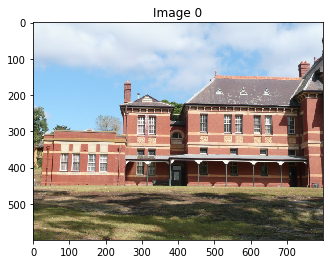

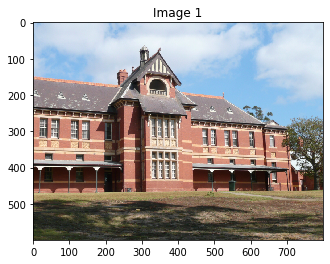

In [301]:
images=load_images(1)

In [302]:
N=400#specify how many maximum descriptors you want in the output
sift = cv2.xfeatures2d.SIFT_create(N)

In [303]:
kp, des = sift.detectAndCompute(images[1], None)
img=np.zeros(images[1].shape)
img=cv2.drawKeypoints(images[1],kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints4.jpg',img)

True

## Saving .mat files

In [304]:
def get_and_save(images,set):
    '''
    A function to save descriptors 
    and keypoints of an image
    '''
    DES=[]
    KP=[]
    for i in range(len(images)):
        kp, des = sift.detectAndCompute(images[i], None)
        KP.append(np.array([[k.pt[0],k.pt[1],k.size,k.angle] for k in kp]))
        DES.append(des)
        scipy.io.savemat('task3/Set'+str(set)+"/mat files/f"+str(i)+'_set'+str(set)+'.mat', {'mydata': KP[i]})
        scipy.io.savemat('task3/Set'+str(set)+"/mat files/d"+str(i)+'_set'+str(set)+'.mat', {'mydata': DES[i]})
    return np.array(KP),np.array(DES)

In [305]:
KP,DES=get_and_save(images,1)

## NNDR Matching

In [306]:
def nndr(des1,des2,th):
    '''
    Implemeted Nearest Neighbour Distance ratio
    '''
    
    N=des1.shape[0]
    m=np.zeros((N,6))
    for i in range(len(des1)):
        for j in range(len(des2)):
            d=np.sqrt(np.sum((des1[i]-des2[j])**2))
            if j==0:
                m[i,0]=d
            elif d<m[i,0]:
                m[i,1]=m[i,0]
                m[i,3]=m[i,2]
                m[i,0]=d
                m[i,2]=j
            elif d<m[i,1] and d>m[i,0]:
                m[i,1]=d
                m[i,3]=j
        if (m[i,0]/m[i,1]<th):
            m[i,4]=1
        m[i,5]=i
            
    return m[np.where(m[:,4]==1)]


## Get all NNDR matches

In [307]:
def get_all_matches(DES,th):
    '''
    Get matches from NNDR between all consecutive images
    '''
    m=[]
    for i in range(len(DES)-1):
        m.append(nndr(DES[i+1],DES[i],th))
    return m

In [308]:
m=get_all_matches(DES,0.7)

/home/junaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


In [309]:
m[0].shape

(80, 6)

## Visualization

In [310]:
def visualize(img1,img2,m,kp1,kp2):
    '''
    A function to visualize matches between two images
    '''
    
    lineThickness=2
    r1,c1=img1.shape[:2]
    r2,c2=img2.shape[:2]
    assert r1==r2
    vis = np.array(np.hstack((img1, img2)))
    vis[:,:c1,:]=img1
    vis[:,c1:,:]=img2
    plt.figure()
    plt.imshow(vis)
    plt.show()
    lineThickness = 2
    for k in range(len(m)):
        if m[k,4]==1:
            vis=cv2.line(vis, ( int(kp1[int(m[k,5]),0]), int(kp1[int(m[k,5]),1]) ), ( int( kp2[int(m[k,2]),0]+c1 ), int(kp2[int(m[k,2]),1]) ), (0,255,0), lineThickness)
    plt.figure(figsize=(20,10))
    plt.imshow(vis)
    plt.show()

    

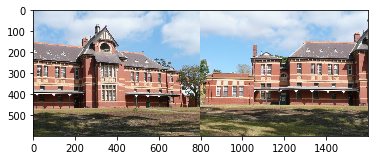

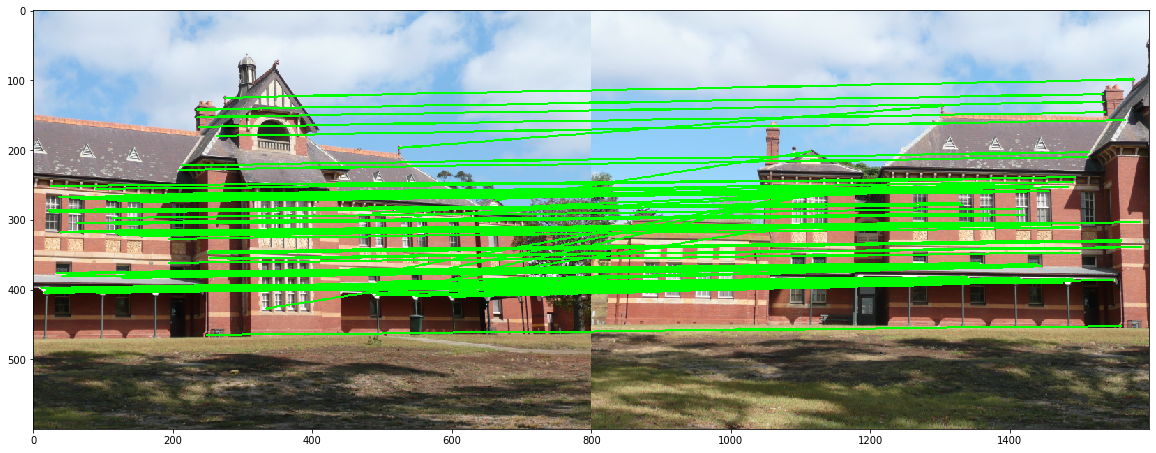

In [311]:
visualize(images[1],images[0],m[0],KP[1],KP[0])

In [312]:
def get_affine_transform(pts1,pts2):
    '''
    A function to recover affine transformation given correspondeces
    '''
    A=np.zeros((len(pts1)*2,6))
    b=np.zeros(len(pts1)*2)
    M=np.zeros((2,3))
    for i in range(len(pts1)):
        A[i*2,0]=pts1[i][0]
        A[i*2,1]=pts1[i][1]
        A[i*2,2]=1
        A[i*2+1,3]=pts1[i][0]
        A[i*2+1,4]=pts1[i][1]
        A[i*2+1,5]=1
        b[i*2]=pts2[i][0]
        b[i*2+1]=pts2[i][1]
        
    P=np.linalg.pinv(A).dot(b)
    M[0,:]=P[:3]
    M[1,:]=P[3:6]
    return M


## Find best transformation by ransac

In [313]:

def ransac(iters,m,kp1,kp2,th):
    '''
    RANSAC algorithm implemented  to get best correspondences
    '''
    n_inliers=0
    pts1=[]
    pts2=[]
    for p in range(len(m)):
        pts1.append(kp1[int(m[p,5]),:2])
        pts2.append(kp2[int(m[p,2]),:2])
    pts1=np.array(pts1)
    pts2=np.array(pts2)    

    for i in range(iters):
        # 3 random points
        rps=np.random.randint(low=0,high=len(m),size=3)
        rps1=[]
        rps2=[]
        for p in rps:
            rps1.append(kp1[int(m[p,5]),:2])
            rps2.append(kp2[int(m[p,2]),:2])

        rps1=np.array(rps1,dtype="int")
        rps2=np.array(rps2,dtype="int")
        T=get_affine_transform(rps1,rps2)
        pts1t=[ T.dot(np.append(p,1)) for p in pts1]
        pts1t=np.array(pts1t)
        dif=np.sqrt(np.sum((pts1t-pts2)**2,-1))
        tmp=pts1[np.where(dif<th)]
        if len(tmp)>n_inliers:
            n_inliers=len(tmp)
            bpts1=tmp
            bpts2=pts2[np.where(dif<th)]

    T=get_affine_transform(bpts1,bpts2)


    return T


## Get all transformations

In [314]:
def get_all_trans(iters,m,KP,th):
    '''
    A method to get all transformations 
    between consecutive images
    '''
    T=[]
    for t in range(len(m)):
        T.append(ransac(iters,m[t],KP[t+1],KP[t],th))
    return T

In [316]:
T=get_all_trans(30,m,KP,0.8)
scipy.io.savemat('task3/Set'+str(1)+"/mat files/transformations.mat", {'mydata': KP[i]})


## Blending images

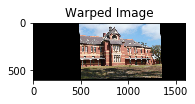

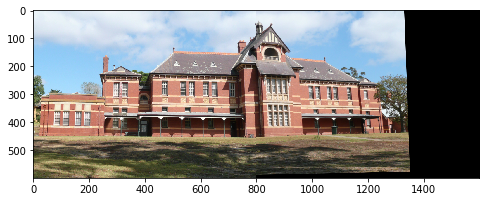

In [263]:
dst = cv2.warpAffine(images[1],T[0],(images[1].shape[1] + images[0].shape[1], images[0].shape[0]))
plt.subplot(122)
plt.imshow(dst)
plt.title('Warped Image')
plt.show()
plt.figure(figsize=(8,16))
dst[0:images[0].shape[0], 0:images[0].shape[1]] = images[0]
# cv2.imwrite(‘output.jpg’,dst)
plt.imshow(dst)
plt.show()

#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Loading images in Set 2

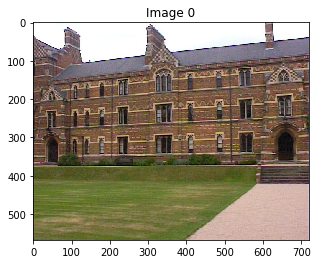

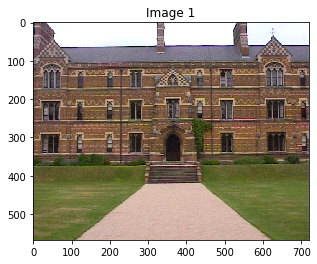

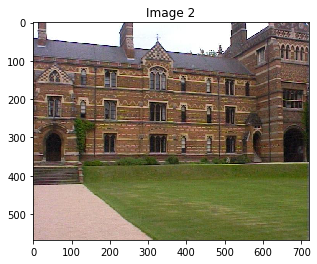

In [264]:
images=load_images(2)

## Saving .mat files

In [265]:
KP,DES=get_and_save(images,2)

## NNDR Matching

In [266]:
m=get_all_matches(DES,0.9)

/home/junaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


In [160]:
m[0].shape

(232, 6)

## Visaulaize matching

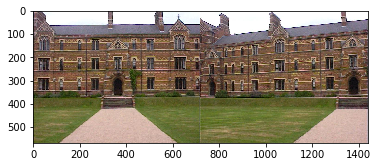

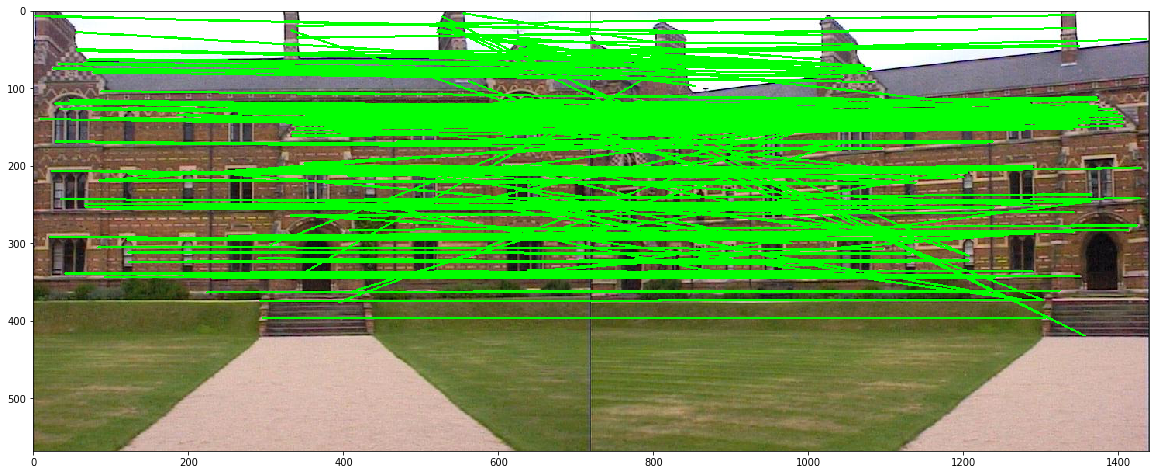

In [267]:
visualize(images[1],images[0],m[0],KP[1],KP[0])

## Get all transformations

In [292]:
T=get_all_trans(20,m,KP,0.8)

In [293]:
len(images)

3

## Blending Images

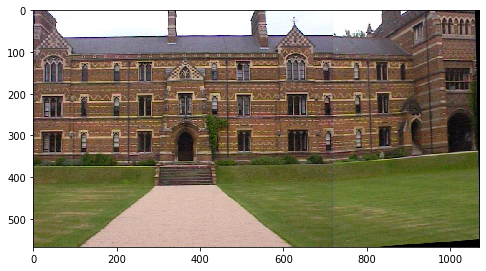

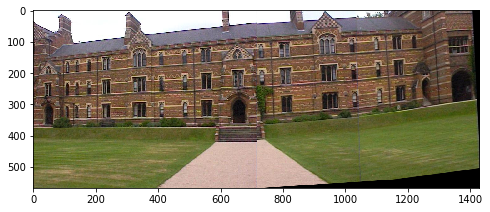

In [294]:

for i,j in enumerate(np.flip(np.arange(len(T)))):
    if i==0:
        dst=images[j+1]
    p1=T[j].dot(np.array([dst.shape[1]-1,dst.shape[0]-1,1],dtype="int"))
    p2=T[j].dot(np.array([dst.shape[1]-1,0,1],dtype="int"))
    dst = cv2.warpAffine(dst,T[j],( int(max(p1[0],p2[0])), images[j].shape[0]))

    plt.figure(figsize=(8,16))
    dst[0:images[j].shape[0], 0:images[j].shape[1]-2] = images[j][:,:-2,:]
    # cv2.imwrite(‘output.jpg’,dst)
    plt.imshow(dst)
    plt.show()


#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Loading images in Set 3

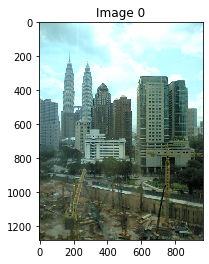

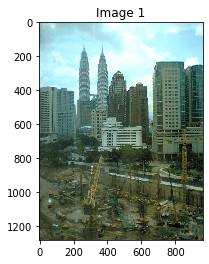

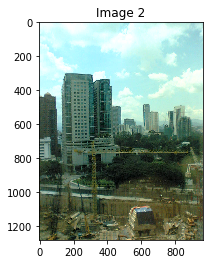

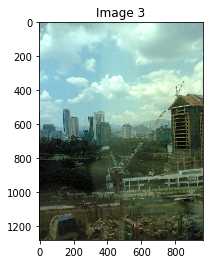

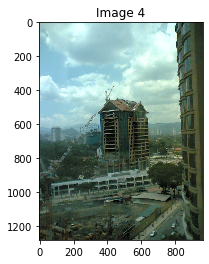

In [235]:
images=load_images(3)

## Saving .mat files

In [236]:
KP,DES=get_and_save(images,3)

## NNDR Matching

In [237]:
m=get_all_matches(DES,0.8)

/home/junaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


## Visaulaize matching

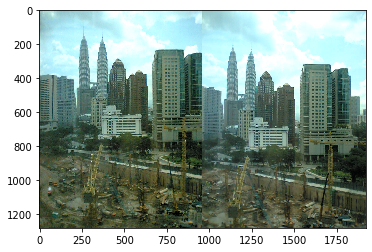

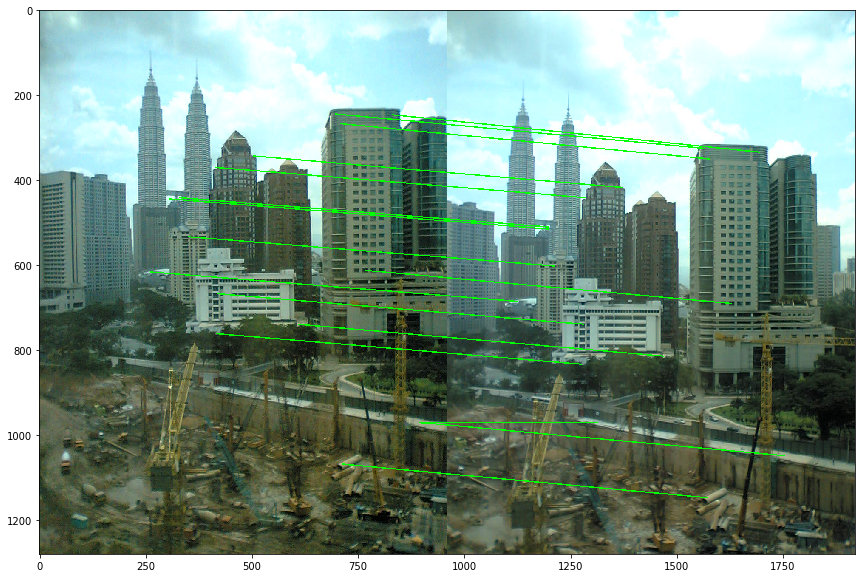

In [168]:
visualize(images[1],images[0],m[0],KP[1],KP[0])

## Get all transformations

In [174]:
T=get_all_trans(30,m,KP,0.7)

## Blending Images

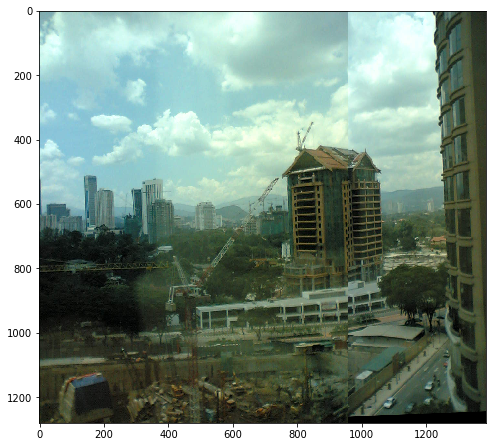

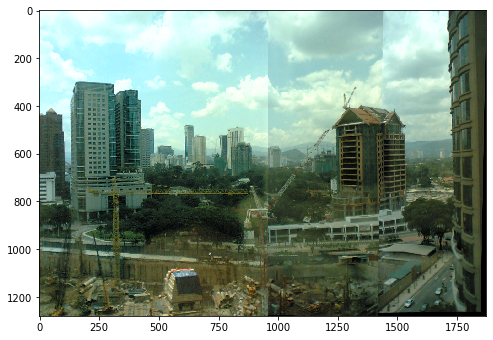

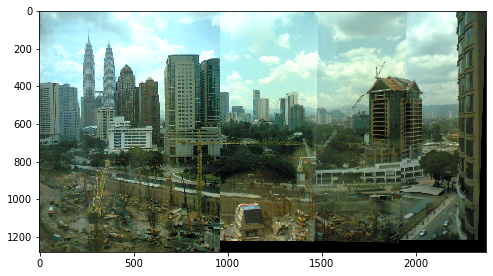

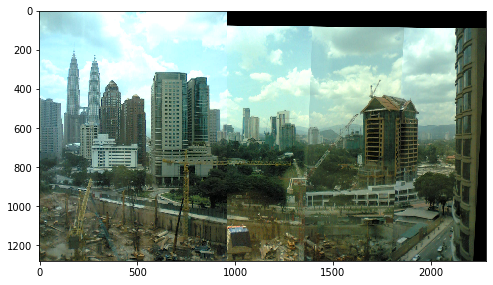

In [175]:

for i,j in enumerate(np.flip(np.arange(len(T)))):
    if i==0:
        dst=images[j+1]
    p1=T[j].dot(np.array([dst.shape[1]-1,dst.shape[0]-1,1],dtype="int"))
    p2=T[j].dot(np.array([dst.shape[1]-1,0,1],dtype="int"))
    dst = cv2.warpAffine(dst,T[j],( int(max(p1[0],p2[0])), images[j].shape[0]))

    plt.figure(figsize=(8,16))
    dst[0:images[j].shape[0], 0:images[j].shape[1]-2] = images[j][:,:-2,:]
    # cv2.imwrite(‘output.jpg’,dst)
    plt.imshow(dst)
    plt.show()


#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Loading images in Set 4

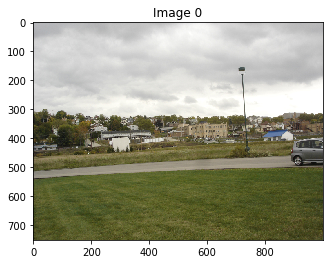

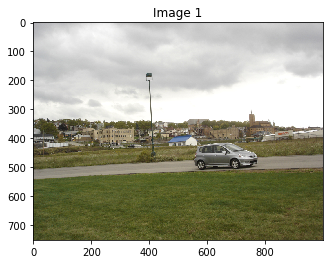

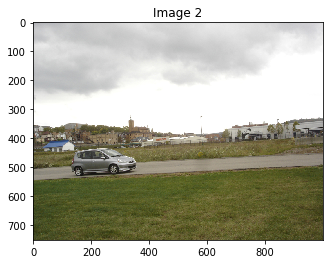

In [295]:
images=load_images(4)

## Saving .mat files

In [296]:
KP,DES=get_and_save(images,4)

## NNDR Matching

In [297]:
m=get_all_matches(DES,0.8)

## Visaulaize matching

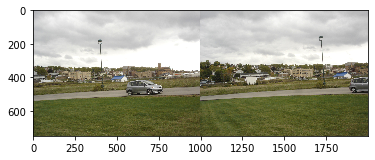

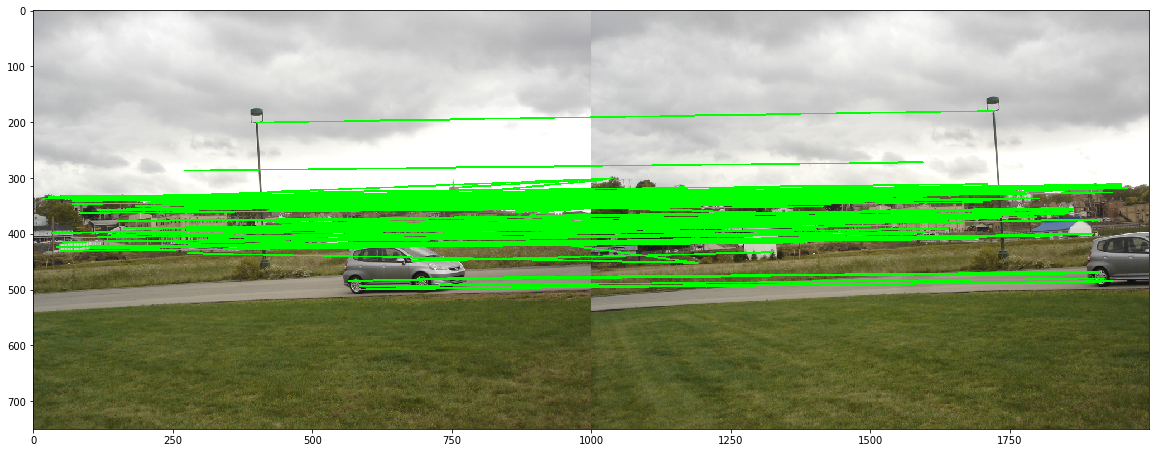

In [298]:
visualize(images[1],images[0],m[0],KP[1],KP[0])

## Get all transformations

In [299]:
T=get_all_trans(50,m,KP,0.7)

## Blending Images

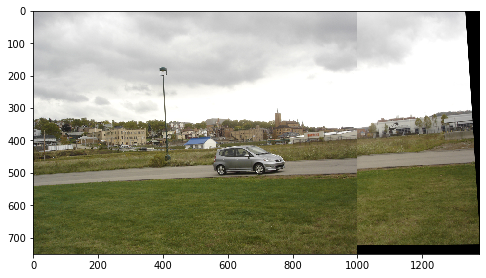

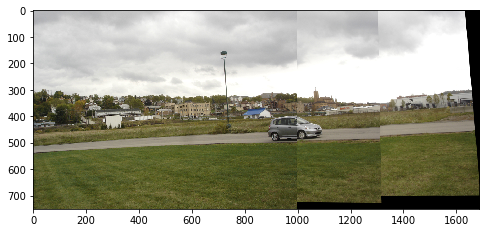

In [185]:

for i,j in enumerate(np.flip(np.arange(len(T)))):
    if i==0:
        dst=images[j+1]
    p1=T[j].dot(np.array([dst.shape[1]-1,dst.shape[0]-1,1],dtype="int"))
    p2=T[j].dot(np.array([dst.shape[1]-1,0,1],dtype="int"))
    dst = cv2.warpAffine(dst,T[j],( int(max(p1[0],p2[0])), images[j].shape[0]))

    plt.figure(figsize=(8,16))
    dst[0:images[j].shape[0], 0:images[j].shape[1]-2] = images[j][:,:-2,:]
    # cv2.imwrite(‘output.jpg’,dst)
    plt.imshow(dst)
    plt.show()
